In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import nnacc
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
data_dir = './demo_data/'

mask = np.loadtxt(data_dir + 'mask_gamma.txt')[:,1].astype(bool)

X_train = np.loadtxt(data_dir + 'X_train.txt')
X_val = np.loadtxt(data_dir + 'X_val.txt')

y_train = np.load(data_dir + 'y_train.npy')[:,mask,1]
y_val = np.load(data_dir + 'y_val.npy')[:,mask,1]

inv_cov = np.load(data_dir + 'invcov_gamma.npy')[:,mask][mask,:]

In [3]:
cov = np.linalg.inv(inv_cov)
sigma = np.sqrt(np.diag(cov))

cov /= sigma[None,:] * sigma[:,None]
y_train /= sigma[None,:]
y_val /= sigma[None,:]

inv_cov = np.linalg.inv(cov)

In [4]:
plow, med, phigh = np.percentile(y_train, [5, 50, 95], axis=0)

bad_inds_train = np.sum(np.abs(y_train - med[None,:]) > 10 * (phigh - plow), axis=-1) > 0
bad_inds_val = np.sum(np.abs(y_val - med[None,:]) > 10 * (phigh - plow), axis=-1) > 0

X_train = X_train[~bad_inds_train,:]
X_val = X_val[~bad_inds_val,:]

y_train = y_train[~bad_inds_train,:]
y_val = y_val[~bad_inds_val,:]

In [5]:
class ArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i,:], self.y[i,:]

In [6]:
batch_size = 128

train_dataset = ArrayDataset(X_train, y_train)
val_dataset = ArrayDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(y_val))

In [7]:
X_mean = torch.tensor(X_train.mean(axis=0), dtype=torch.float32)
X_std = torch.tensor(X_train.std(axis=0), dtype=torch.float32)

class X_transform(nn.Module):
    def __init__(self, X_mean=None, X_std=None):
        super(X_transform, self).__init__()
        
        self.X_mean = nn.Parameter(X_mean)
        self.X_std = nn.Parameter(X_std)
        
    def forward(self, X):
        return (X - self.X_mean[None,:]) / self.X_std[None,:]

y_mean = torch.tensor(y_train.mean(axis=0), dtype=torch.float32)
y_std = torch.tensor(y_train.std(axis=0), dtype=torch.float32)

class y_transform(nn.Module):
    def __init__(self, y_mean=None, y_std=None):
        super(y_transform, self).__init__()
        
        self.y_mean = nn.Parameter(y_mean)
        self.y_std = nn.Parameter(y_std)
        
    def forward(self, y):
        return y * self.y_std[None,:] + self.y_mean[None,:]

In [8]:
inv_cov_tensor = torch.tensor(inv_cov, dtype=torch.float32)

def loss_fn(y_pred, y_target):
    delta = y_pred - y_target
    chisq = torch.sum((delta @ inv_cov_tensor) * delta, dim=-1)
    
    loss = torch.mean(chisq) / y_target.shape[-1]
    
    return loss

def val_metric_fn(y_pred, y_target):
    delta = y_pred - y_target
    chisq = torch.sum((delta @ inv_cov_tensor) * delta, dim=-1)
    
    mean_chisq_dof = torch.mean(chisq) / y_target.shape[-1]
    max_chisq_dof = torch.max(chisq) / y_target.shape[-1]
    
    return torch.tensor([mean_chisq_dof, max_chisq_dof])

In [9]:
model = nnacc.Predictor(X_train.shape[-1], y_train.shape[-1], X_transform=X_transform(X_mean, X_std), y_transform=y_transform(y_mean, y_std))

In [10]:
num_epochs = 50

train_loss, val_metric = model.train(train_loader, num_epochs, loss_fn, val_loader, val_metric_fn)

  0%|          | 0/50 [00:00<?, ?it/s]

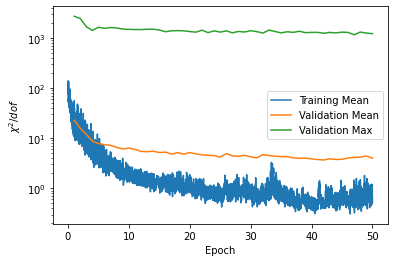

In [11]:
plt.plot(np.linspace(0, num_epochs, len(train_loss)), train_loss, label='Training Mean')
plt.plot(np.arange(1, num_epochs+1), val_metric[:,0], label='Validation Mean')
plt.plot(np.arange(1, num_epochs+1), val_metric[:,1], label='Validation Max')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('$\\chi^2 / dof$')
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), data_dir + 'model.pt')